# Анализ оттока клиентов банка

## Общие сведения

**Основная цель проекта: снизить отток клиентов банка.**

**Способ достижения цели:** выделить сегменты клиентов, наиболее склонные к оттоку, и представить рекомендации по их удержанию.

Под оттоком в рамках проекта понимается полное прекращение взаимодействия клиента с банком и закрытие им всех имеющихся продуктов.

Заказчик - менеджер отдела маркетинга банка, требующий результат в виде презентации.
Потребность в исследовании потребовалась в связи с возросшим оттоком клиентов в последнее время.
Ранее подобное исследование проводилось, но его результаты не актуальны.

Исходные данные представлены в файле `bank_scrooge.csv`, содержащем сведения о всех актуальных клиентах и содержат следующие столбцы:
* USERID — идентификатор пользователя,
* score — баллы кредитного скоринга,
* city — город,
* gender — пол,
* age — возраст,
* equity — количество баллов собственности,
* balance — баланс на счёте,
* products — количество продуктов, которыми пользуется клиент,
* credit_card — есть ли кредитная карта,
* last_activity — активность клиента за последние 3 месяца,
* EST_SALARY — оценочный доход клиента,
* сhurn — признак оттока, показывающий, что клиент изъявил желание расторгнуть все отношения с банком.

## Изучение данных и предобработка

### Первичное изучение данных

Устанавливаем и импортируем все используемые в проекте библиотеки:

In [1]:
import sys
!{sys.executable} -m pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats as st
import statsmodels.api as sm
from itertools import combinations

Загрузим исходные данные и проведем их первичный анализ:

In [3]:
df = pd.read_csv('/bank_scrooge.csv')

In [4]:
print(df.shape)
df.head()

(10000, 12)


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Приведем названия столбцов к нижнему регистру для удобства дальнейшей работы:

In [7]:
df.columns = df.columns.str.lower()
df.rename(columns={'userid': 'user_id'}, inplace=True)

In [8]:
df.groupby('churn')['churn'].count()

churn
0    8180
1    1820
Name: churn, dtype: int64

In [9]:
# проверяем, есть ли в score нецелые значения
len(df.query("(score * 10 % 10) != 0"))

0

In [10]:
print('Имеются сведения о клиентах из городов:', ', '.join(df['city'].unique()))
print('Уникальные значения столбца с полом:', ', '.join(df['gender'].unique()))

Имеются сведения о клиентах из городов: Рыбинск, Ярославль, Ростов
Уникальные значения столбца с полом: Ж, М


В рамках первичного анализа выявлено:
* К анализу представлено 10000 строк о клиентах банка с 12 уникальными признаками.
* В столбце с балансом клиентов на счету `balance` обнаружено **свыше 20% пропусков**, в столбце с возрастом клиентов - 26 пропусков (менее 0,5% данных).
* Данные, представленные в столбцах, лежат в рамках адекватных значений. Явных ошибок не обнаружено.
* Данные в столбцах `score` и `age` можно привести к типу целых чисел, т.к. они не содержат дробных значений. 
* Среди всех действующих клиентов 18,2% попали в отток.

### Кодирование признаков

Для построения в будущем корреляций с категориальными признаками (городом клиента `city` и полом `gender`), перейдем от них к фиктивным переменным, создав новые столбцы:

In [11]:
df = df.join(
    pd.get_dummies(df, columns=['city', 'gender']).iloc[:, [10, 11, 12, 13, 14]]
)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


Переименуем новые столбцы:

In [12]:
df = df.rename(columns={'city_Ростов': 'city_ros',
                        'city_Рыбинск': 'city_ryb',
                        'city_Ярославль': 'city_yar',
                        'gender_Ж': 'gender_f',
                        'gender_М': 'gender_m'})

### Обработка пропусков и дубликатов

Начнем с исследования пропусков в столбце с балансом счета клиентов - `balance`. Исследуем средние значения среди клиентов,  где не указан размер баланса, сравним с теми, где данные указаны:

In [13]:
pd.concat([df.query('balance.isna()').mean(), df.query('~balance.isna()').mean()], axis=1)

,0,1
user_id,172069.447930,171738.837508
score,865.352070,843.739260
age,42.093023,42.924366
equity,0.050980,3.395068
balance,NaN,827794.306510
products,1.162092,2.080986
credit_card,0.815686,0.640104
last_activity,0.549455,0.515769
est_salary,226310.208654,124501.872366
churn,0.005664,0.234523


Сравнивая средние значения среди тех строк, где есть пропуски в столбце с балансом, со средними значениями всех строк, можно заметить:
* Среднее значение `equity` заметно ниже.
* Среднее значение `churn` крайне мало - отточных клиентов практически нет среди строк с пропусками в балансе.
* У таких клиентов в среднем чаще есть кредитная карта - это видно по значению `credit_card`, а также есть немалая вероятность, что кредитка - единственный продукт, который есть у клиента.
* Предполагаемый доход клиентов с неуказанным балансом в среднем выше, чем у всех клиентов.

Теперь создадим новый столбец `na_balance`, в котором укажем `1`, если в строке отсутствует значение баланса и `0` в обратном случае, и найдем зависимости с другими признаками:

In [14]:
df['na_balance'] = np.where(df['balance'].isna(), 1, 0)

In [15]:
df.corr()['na_balance'].sort_values(ascending=False)

na_balance       1.000000
est_salary       0.307154
credit_card      0.158334
score            0.138871
gender_m         0.063424
city_yar         0.055919
last_activity    0.028362
user_id          0.004125
city_ryb        -0.013668
age             -0.028659
city_ros        -0.061508
gender_f        -0.063424
churn           -0.249421
products        -0.487512
equity          -0.709951
balance               NaN
Name: na_balance, dtype: float64

По шкале Чеддока обнаружена высокая отрицательная корреляция со значением количества баллов собственности `equity`, средняя отрицательная корреляция с количеством продуктов клиента `products` и слабая корреляция с предполагаемым доходом `est_salary` и фактом оттока `churn`.

Изучим подробнее значения `equity`, `churn` и `products`: найдем распределение среди строк с пропусками в `balance` по данным признакам:

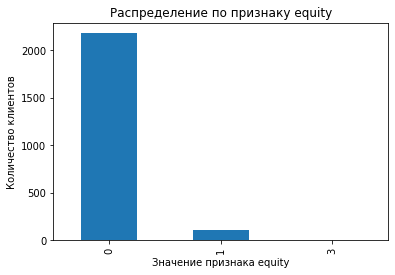

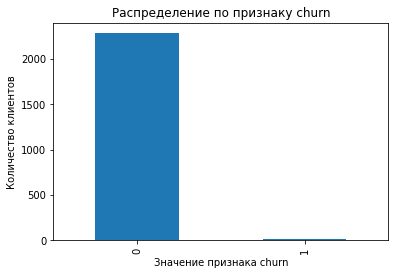

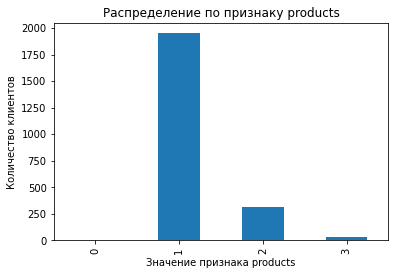

In [16]:
for attr in ['equity', 'churn', 'products']:
    df.query('balance.isna()').groupby(attr)[attr].count().plot(kind='bar')
    plt.title(f'Распределение по признаку {attr}')
    plt.xlabel(f'Значение признака {attr}')
    plt.ylabel('Количество клиентов')
    plt.show()

Заметим, что практически все клиенты с пропущенным значением баланса имеют 0 баллов недвижимости и не попали в отток. Проверим, сколько найдется клиентов с такими же параметрами, но для которых указан размер баланса:

In [17]:
df.query('equity == 0 and churn == 0 and ~balance.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
84,221446,785.0,Рыбинск,Ж,32.0,0,35867.00,1,1,0,140486.76,0,0,1,0,1,0,0
213,141896,845.0,Ростов,Ж,41.0,0,179615.20,2,0,0,196600.10,0,1,0,0,1,0,0
273,144352,977.0,Ростов,Ж,36.0,0,26312.31,1,1,1,140598.20,0,1,0,0,1,0,0
328,213071,785.0,Ярославль,М,31.0,0,114718.19,1,1,1,67726.52,0,0,0,1,0,1,0
343,147612,814.0,Ярославль,Ж,61.0,0,97174.81,2,1,0,108413.26,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9828,178980,780.0,Ярославль,Ж,37.0,0,234063.47,3,0,0,97867.41,0,0,0,1,1,0,0
9915,207927,782.0,Ярославль,М,47.0,0,198054.97,1,1,1,124705.98,0,0,0,1,0,1,0
9979,191231,766.0,Ярославль,Ж,63.0,0,232261.19,2,0,1,90311.96,0,0,0,1,1,0,0
9982,207449,735.0,Рыбинск,Ж,35.0,0,39241.88,1,1,0,41873.02,0,0,1,0,1,0,0


In [18]:
len(df.query('equity == 0 and churn == 0 and balance.isna()'))

2168

Нашлось 334 строки, где по заданным признакам указан баланс, и 2168 строк (почти 95% всех пропусков `balance`), где баланс не указан. Значит, пропуски имеют не случайный характер - клиенты с указанным набором признаков чаще имеют пропуск в значении баланса, чем остальные.

**Резюмируя вышесказанное, делаем вывод, что пропуски в столбце с балансом имеют тип MAR, поскольку обнаружена зависимость между наличием пропуска в данном столбце и признаками `equity` и `churn`.** Эту связь можно объяснить, например, следующим образом:
* Пропуски возникли из-за операций, которые клиенты недавно проводили с недвижимостью (покупка и/или продажа имущества, влекущие значительные изменения в балансе).
* Сведения в `equity` подгружаются, вероятно, с других ресурсов (например, с госуслуг на основании паспортных данных), но из-за сбоев в рамках данного процесса в `equity` автоматически устанавливается нулевое значение, а в `balance`, ввиду особенностей дата-инжиниринга, указывается пропуск.

Чтобы определить, возможно ли заполнить пропуски в балансе на основе других признаков, проверим наличие корреляций баланса с другими признаками:

In [19]:
df.corr()['balance'].sort_values(ascending=False)

balance          1.000000
est_salary       0.339622
score            0.235812
equity           0.164126
churn            0.085577
products         0.075684
age              0.069745
city_yar         0.057342
gender_m         0.051711
last_activity    0.025004
user_id          0.006133
city_ryb        -0.034697
city_ros        -0.035805
gender_f        -0.051711
credit_card     -0.059253
na_balance            NaN
Name: balance, dtype: float64

Заметна слабая корреляция баланса с предполагаемым доходом клиента и баллом кредитного скоринга.

В дальнейшем заполним пропуски в балансе с применением модели линейной регрессии. Но прежде, чем заполнять пропуски в `balance`, рассмотрим пропуски в столбце `age`:

In [20]:
df.query('age.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,0,0,1,0,1,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,0,1,0,1,0,1
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0,0,0,1,0,1,1
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,1,0,0,1,0,0
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0,0,1,0,0,1,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,0,1,0,1,0,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,0,1,0,1,0,1
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0,0,1,0,1,0,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,0,1,0,1,0,1
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,0,0,1,1,0,0


Как можно заметить, многие из строк, в которых пропущен возраст, также пропущено и значение баланса. Для всех таких строк характерно также значение `equity` равное нулю, количество продуктов `products` равное единице и нулевой признак отточности. Скорее всего, такие строки появились по описанной ранее причине: данные подтягивались со стороннего сервиса, но из-за сбоев или ошибок в сохранении данных, эти сведения остались незаполненными.

Рассмотрим подробнее некоторые из этих строк по `user_id`:

In [21]:
display(df.query('user_id == 206759'))
display(df.query('user_id == 187635'))
display(df.query('user_id == 219343'))
display(df.query('user_id == 221809'))
display(df.query('user_id == 185829'))

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
5889,206759,917.0,Ярославль,М,22.0,0,NaN,1,1,0,70617.52,0,0,0,1,0,1,1
8385,206759,915.0,Рыбинск,М,NaN,0,NaN,1,1,0,71179.53,0,0,1,0,0,1,1


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
918,187635,918.0,Ярославль,Ж,44.0,0,NaN,1,1,1,162497.52,0,0,0,1,1,0,1
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,0,1,0,1,0,1


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
1010,219343,921.0,Ярославль,Ж,33.0,0,NaN,1,1,0,159475.61,0,0,0,1,1,0,1
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,0,1,0,1,0,1


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
9322,221809,917.0,Рыбинск,М,45.0,0,NaN,1,1,1,199728.29,0,0,1,0,0,1,1
9634,221809,917.0,Ярославль,М,NaN,0,NaN,1,1,1,192644.15,0,0,0,1,0,1,1


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
3668,185829,925.0,Рыбинск,М,40.0,0,NaN,1,1,0,228305.64,0,0,1,0,0,1,1
9632,185829,927.0,Ярославль,М,NaN,0,NaN,1,1,0,231254.86,0,0,0,1,0,1,1


Обнаружена интересная закономерность: все строки, имеющие пропуски в `age` и `balance`, обладают дубликатами по `user_id`. Судя по значениям города, пола клиента и предполагаемого дохода, а также сходств в прочих признаках, можно сделать предположение о том, что **указанные клиенты остались в базах данных двух городов: при этом речь идет именно об одном и том же клиенте.**

Таким образом, можно сделать вывод о том, что эти строки являются дубликатами. Чтобы корректно их обработать, можно оставить только те строки, которые содержат сведения о возрасте клиента, а в фиктивных переменных с городами указать `1` во всех городах, где о клиенте есть данные.

Однако прежде, чем обработать эти строки, изучим все явные дубликаты и строки с дубликатами в `user_id`, чтобы удостовериться в выдвинутом предположении:

In [22]:
print("Количество явных дубликатов:", df.duplicated().sum())

Количество явных дубликатов: 0


In [23]:
duplicated_user_id = list(df[df['user_id'].duplicated()].sort_values(by='user_id')['user_id'])
print('Общее количество дубликатов по user_id:', len(duplicated_user_id))
df.query('user_id in @duplicated_user_id').sort_values(by='user_id').head(10)

Общее количество дубликатов по user_id: 73


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,1,0,1,0,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,0,0,1,1,0,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,0,0,1,1,0,1
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,1,0,1,0,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,0,0,1,0,1,1
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,1,0,1,0,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,0,0,1,1,0,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,0,1,0,0,1,1
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,0,0,1,1,0,0
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0,1,0,1,0,0


Нашлось 73 строки-дубликата по `user_id`. Строки с одинаковыми `user_id` не всегда содержат сведения об одном и том же клиенте: это можно понять по некоторым строкам, где у клиентов отличается пол, сильно отличается значение в доходе и количестве продуктов.

Для тех строк, где пол одинаковый, а разница в возрасте, кредитном рейтинге и ожидаемом доходе незначительна, можно сделать вывод о том, что это, скорее всего, запись об одном и том же человеке, который спустя время открыл счет в банке другого города, попав также в базу данных банка этого города. Найдем, сколько таких строк: будем считать, что речь идет об одном и том же клиенте, если пол - одинаковый, разница в возрасте - не более 1 года (либо неизвестна), разница в кредитном рейтинге - не более 20 единиц, а разница в предполагаемом доходе составляет не более 10000 руб.:

In [24]:
duplicated_users_diff = df.query(
    'user_id in @duplicated_user_id'
).sort_values(by='user_id')[['user_id', 'score', 'gender_f', 'age', 'est_salary']].diff()

duplicated_users_diff_same_users = \
    duplicated_users_diff.query('user_id == 0 and\
                                 abs(score) <= 20\
                                 and (abs(age) <= 1 or age.isnull())\
                                 and gender_f == 0\
                                 and abs(est_salary) <= 10000')
print('Нашлось одинаковых пользователей:', len(duplicated_users_diff_same_users))
duplicated_users_diff_same_users

Нашлось одинаковых пользователей: 12


,user_id,score,gender_f,age,est_salary
9457,0.0,0.0,0.0,NaN,0.00
3668,0.0,-2.0,0.0,NaN,-2949.22
4720,0.0,1.0,0.0,NaN,2875.22
8897,0.0,-1.0,0.0,NaN,-4455.89
8385,0.0,-2.0,0.0,NaN,562.01
4401,0.0,-1.0,0.0,NaN,-3639.92
5470,0.0,2.0,0.0,NaN,-249.53
7248,0.0,-1.0,0.0,NaN,-226.94
9322,0.0,0.0,0.0,NaN,7084.14
6446,0.0,0.0,0.0,NaN,703.81


In [25]:
df.query('user_id in @duplicated_user_id')['city'].unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

Таких клиентов нашлось всего 12 штук. Все остальные строки, скорее всего, имеют информацию о разных клиентах при одинаковом `user_id` по причине того, что в базах данных разных городов могут использоваться одинаковые `user_id`.

**Резюмируя обнаруженные закономерности и особенности, принимаем следующие решения по обработке дубликатов и пропусков:**
* Обнаруженные 12 строк-дубликатов, с высокой вероятностью содержащих сведения об одних и тех же клиентах, удаляем, при этом указывая в "строках-оригиналах" оба города, в базах которых есть клиент: Ярославль и Рыбинск, а в столбце с возрастом `age` указываем имеющуюся информацию о возрасте.
* Остальные строки-псевдо-дубликаты (в количестве 61 строки) считаем уникальными клиентами, для которых ошибочно указан одинаковый `user_id` в базах банков Ярославля и Рыбинска. Во избежание ошибок в дальнейшем, переприсвоим значения `user_id` значениями индексов.
* Оставшиеся пропуски в столбце `age` заполним медианным значением возраста. Такое заполнение пропусков не внесет ошибок в данные, поскольку количество таких пропусков незначительно (менее 0.5% от общего количества строк).
* Пропуски в `balance` заполним с использованием модели линейной регрессии.

In [26]:
# сохраняем список и возраст user_id, дубликаты которых удалим
deleted_user_id = list(df.query('index in @duplicated_users_diff_same_users.index')['user_id'])
deleted_age = list(df.query('index in @duplicated_users_diff_same_users.index')['age'])

# удаляем строки-дубликаты
df = df.query('index not in @duplicated_users_diff_same_users.index')

# указываем для "строк-оригиналов" в качестве город Рыбинск и Ярославль
for i in range(len(deleted_user_id)):
    df.loc[(df.user_id == deleted_user_id[i]), ('city')] = 'Ярославль, Рыбинск'
    df.loc[(df.user_id == deleted_user_id[i]), ('city_yar', 'city_ryb')] = 1
    if not(np.isnan(deleted_age[i])):
        df.loc[(df.user_id == deleted_user_id[i]), ('age')] = deleted_age[i]

# переопределяем все user_id, чтобы считать всех оставшихся клиентов уникальными
df.reset_index(inplace=True, drop=True)
df['user_id'] = df.index

# заполняем оставшиеся пропуски в age медианным значением возраста
df['age'] = df['age'].fillna(df['age'].median())

Чтобы заполнить пропуски в балансе, выберем для модели линейной регрессии признаки, показавшие раньше более высокое значение корреляции с балансом, чем другие: `est_salary`, `score` и `equity`. Перед применением их в модели, проверим, нет ли между ними сильной корреляции:

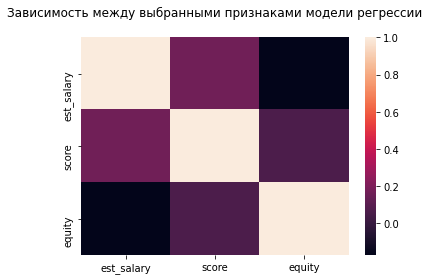

In [27]:
sns.heatmap(df.corr()[['est_salary', 'score', 'equity']].loc[['est_salary', 'score', 'equity']])
plt.title('Зависимость между выбранными признаками модели регрессии\n');

Корреляция между признаками очень слабая либо отсутствует полностью. Значит, можем использовать их в ML-модели регрессии. Чтобы впоследствии оценить эффективность примененной модели, сохраним медианное значение баланса, стандартное отклонение данное величины и исходное распределение значений баланса для его сравнения с итоговым, с заполненными пропусками:

In [28]:
median_balance_before_fillna = round(df.query('~balance.isna()')['balance'].median())
distr_balance_before_fillna = df['balance'].copy()

print('Медианное значение баланса до заполнения:', median_balance_before_fillna, 'у.е.')
print('Стандартное отклонение баланса до заполнения:', round(df.query('~balance.isna()')['balance'].std()), 'у.е.')

Медианное значение баланса до заполнения: 524284 у.е.
Стандартное отклонение баланса до заполнения: 1980987 у.е.


In [29]:
# выделяем обучающую выборку и тестовую, содержащую пропуски в балансе
X_train = df.query('~balance.isna()')[['est_salary', 'score', 'equity']]
y_train = df.query('~balance.isna()')['balance']
X_test = df.query('balance.isna()')[['est_salary', 'score', 'equity']]

# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучаем модель и прогнозируем значение баланса
model = LinearRegression()
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

# заполняем пропуски прогнозными значениями,
# заменив отрицательные значения нулевыми, а превышающие 4 миллиона - аналогичным значением
for i in range(len(predictions)):
    if predictions[i] < 0:
        predictions[i] = 0
    elif predictions[i] > 4_000_000:
        predictions[i] = 4_000_000
    df.at[X_test.index[i], 'balance'] = predictions[i]

Разница в медианном значении баланса: 67429 у.е.


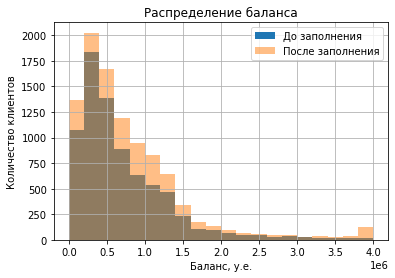

In [30]:
print('Разница в медианном значении баланса:', round(df['balance'].median() - median_balance_before_fillna), 'у.е.')

distr_balance_before_fillna.hist(range=(0, 4_000_001), bins=20)
df['balance'].hist(range=(0, 4_000_001), bins=20, alpha=0.5)

plt.title('Распределение баланса')
plt.xlabel('Баланс, у.е.')
plt.ylabel('Количество клиентов')
plt.legend(['До заполнения', 'После заполнения']);

Полученная разница в медианном значении баланса допустима: её значение намного ниже, чем ранее рассчитанное стандартное отклонение баланса. Также, анализируя гистограмму, можно заметить совсем небольшой перекос в сторону значений, равных 4 миллионам у.е. и равных нулю. Остальные значения баланса встретились примерно с той же частотой, что и в исходном датафрейме без пропусков. **Таким образом, делаем вывод о том, что заполнение пропусков значениями, построенными в соответствии с регрессионной моделью, удовлетворительны.**

Проверим результаты работы с пропусками и дубликатами:

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9988 non-null   int64  
 1   score          9988 non-null   float64
 2   city           9988 non-null   object 
 3   gender         9988 non-null   object 
 4   age            9988 non-null   float64
 5   equity         9988 non-null   int64  
 6   balance        9988 non-null   float64
 7   products       9988 non-null   int64  
 8   credit_card    9988 non-null   int64  
 9   last_activity  9988 non-null   int64  
 10  est_salary     9988 non-null   float64
 11  churn          9988 non-null   int64  
 12  city_ros       9988 non-null   uint8  
 13  city_ryb       9988 non-null   uint8  
 14  city_yar       9988 non-null   uint8  
 15  gender_f       9988 non-null   uint8  
 16  gender_m       9988 non-null   uint8  
 17  na_balance     9988 non-null   int64  
dtypes: float

In [32]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m,na_balance
0,0,850.0,Рыбинск,Ж,25.0,1,5.921482e+04,2,0,1,75719.14,1,0,1,0,1,0,0
1,1,861.0,Рыбинск,Ж,37.0,5,8.505943e+05,3,1,0,86621.77,0,0,1,0,1,0,0
2,2,892.0,Рыбинск,Ж,30.0,0,5.246229e+05,1,1,1,107683.34,0,0,1,0,1,0,1
3,3,866.0,Ярославль,Ж,51.0,5,1.524746e+06,2,0,1,174423.53,1,0,0,1,1,0,0
4,4,730.0,Ярославль,М,34.0,5,1.740000e+02,1,1,0,67353.16,1,0,0,1,0,1,0


Все пропуски заполнены успешно, а дубликаты обработаны. Столбец `na_balance` теперь можно удалить за ненадобностью:

In [33]:
del df['na_balance']

### Обработка аномалий

In [34]:
df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m
count,9988.000000,9988.000000,9988.000000,9988.000000,9.988000e+03,9988.000000,9988.000000,9988.000000,9.988000e+03,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,4993.500000,848.642571,42.731177,2.629656,8.793060e+05,1.870845,0.680116,0.523528,1.478494e+05,0.182219,0.141870,0.269824,0.589507,0.499700,0.500300
std,2883.431578,65.443806,12.171578,1.980254,1.799427e+06,0.792689,0.466455,0.499471,1.394398e+05,0.386044,0.348934,0.443890,0.491948,0.500025,0.500025
min,0.000000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2496.750000,802.000000,33.000000,0.000000,3.166581e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4993.500000,853.000000,40.000000,3.000000,5.917130e+05,2.000000,1.000000,1.000000,1.196268e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,7490.250000,900.000000,51.000000,4.000000,1.077781e+06,2.000000,1.000000,1.000000,1.744938e+05,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,9987.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Заметим, что в столбцах `balance` и `est_salary` есть сильно выбивающиеся высокие значения.

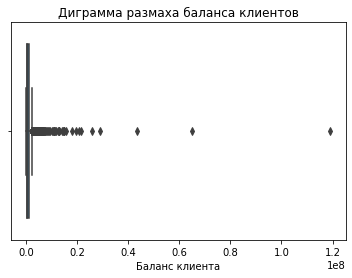

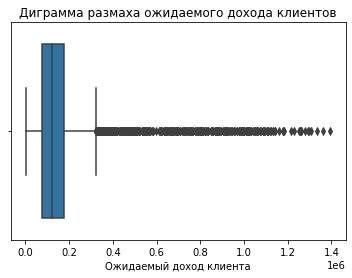

In [35]:
def boxplot_balance_and_est_salary():
    sns.boxplot(
        data=df,
        x='balance'
    )
    plt.title('Диграмма размаха баланса клиентов')
    plt.xlabel('Баланс клиента')
    plt.show()

    sns.boxplot(
        data=df,
        x='est_salary'
    )
    plt.title('Диграмма размаха ожидаемого дохода клиентов')
    plt.xlabel('Ожидаемый доход клиента')
    plt.show()
    
boxplot_balance_and_est_salary()

In [36]:
print('Количество клиентов с балансом выше 5 миллионов:', len(df.query('balance > 0.5*10**7')))
df.query('balance > 0.5*10**7').groupby('churn')['churn'].count()

Количество клиентов с балансом выше 5 миллионов: 73


churn
0    47
1    26
Name: churn, dtype: int64

In [37]:
print('Количество клиентов с ожидаемым доходом выше 600 тысяч:', len(df.query('est_salary > 0.6*10**6')))
df.query('est_salary > 0.6*10**6').groupby('churn')['churn'].count()

Количество клиентов с ожидаемым доходом выше 600 тысяч: 227


churn
0    199
1     28
Name: churn, dtype: int64

Избавимся от обнаруженных строк, содержащих слишком большие значения баланса и заработной платы. Поскольку количество пользователей не столь значительно, а также среди них довольно мало отточных, удаление данных не нанесет вреда и позволит избавиться от сильно выбивающихся из общей массы значений.

In [38]:
df = df.query('~(balance > 0.5*10**7 or est_salary > 0.6*10**6)')

Вновь построим диаграммы размаха:

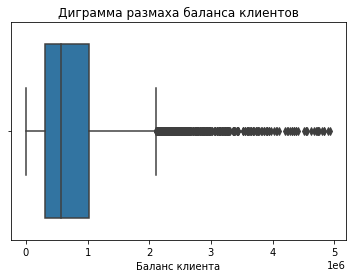

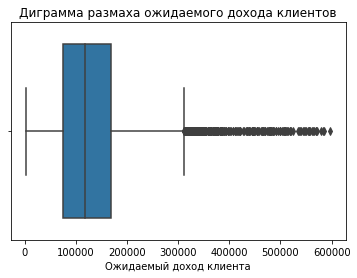

In [39]:
boxplot_balance_and_est_salary()

In [40]:
print('Доля оставшихся отточных пользователей, имеющих аномальные значения баланса и/или дохода:',\
      round(len(df.query('(balance > 2*10**6 or est_salary > 3*10**5) and churn == 1')) / \
            len(df.query('churn==1')), 2) * 100, '%')

Доля оставшихся отточных пользователей, имеющих аномальные значения баланса и/или дохода: 11.0 %


Несмотря на то, что диаграммы размаха всё ещё показывают аномальные значения, считаем обработку аномалий достаточной, т.к. дальнейшее удаление строк с аномалиями может исказить результаты и навредить исследованию, затронув 11% от всех строк с отточными клиентами.

Теперь проверим клиентов по количеству продуктов:

In [41]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_ros,city_ryb,city_yar,gender_f,gender_m
8947,8947,962.0,Рыбинск,Ж,79.0,3,725700.448181,0,0,0,25063.96,1,0,1,0,1,0


Заметим, что нашелся странный клиент с нулем продуктов. Избавимся от него:

In [42]:
df = df.query('products != 0')

### Приведение типов данных

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 9987
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9724 non-null   int64  
 1   score          9724 non-null   float64
 2   city           9724 non-null   object 
 3   gender         9724 non-null   object 
 4   age            9724 non-null   float64
 5   equity         9724 non-null   int64  
 6   balance        9724 non-null   float64
 7   products       9724 non-null   int64  
 8   credit_card    9724 non-null   int64  
 9   last_activity  9724 non-null   int64  
 10  est_salary     9724 non-null   float64
 11  churn          9724 non-null   int64  
 12  city_ros       9724 non-null   uint8  
 13  city_ryb       9724 non-null   uint8  
 14  city_yar       9724 non-null   uint8  
 15  gender_f       9724 non-null   uint8  
 16  gender_m       9724 non-null   uint8  
dtypes: float64(4), int64(6), object(2), uint8(5)
memory 

Приведем значение в столбце `score` к целочисленному типу данных uint16, а столбцы `equity`, `age`, `churn`, `products`, `credit_card` и `last_activity` - к типу uint8:

In [44]:
df['score'] = df['score'].astype('uint16')
df['equity'] = df['equity'].astype('uint8')
df['age'] = df['age'].astype('uint8')
df['churn'] = df['churn'].astype('uint8')
df['products'] = df['products'].astype('uint8')
df['credit_card'] = df['credit_card'].astype('uint8')
df['last_activity'] = df['last_activity'].astype('uint8')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 9987
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9724 non-null   int64  
 1   score          9724 non-null   uint16 
 2   city           9724 non-null   object 
 3   gender         9724 non-null   object 
 4   age            9724 non-null   uint8  
 5   equity         9724 non-null   uint8  
 6   balance        9724 non-null   float64
 7   products       9724 non-null   uint8  
 8   credit_card    9724 non-null   uint8  
 9   last_activity  9724 non-null   uint8  
 10  est_salary     9724 non-null   float64
 11  churn          9724 non-null   uint8  
 12  city_ros       9724 non-null   uint8  
 13  city_ryb       9724 non-null   uint8  
 14  city_yar       9724 non-null   uint8  
 15  gender_f       9724 non-null   uint8  
 16  gender_m       9724 non-null   uint8  
dtypes: float64(2), int64(1), object(2), uint16(1), uint8

Замены типов данных прошли успешно, а количество используемой памяти удалось сократить почти вдвое.

**Подведем итоги этапа изучения и предварительной обработки данных:**
1. К анализу было представлено 10000 строк о клиентах банка с 12 уникальными признаками. Данные, представленные в столбцах, лежат в рамках адекватных значений. Явных ошибок не обнаружено.
2. Среди всех действующих клиентов 18,2% попали в отток, т.е. изъявили желание об уходе из банка.
3. Проведено кодирование категориальных признаки с наименованием города и полом с помощью фиктивных переменных.
4. Выявлено, что пропуски в столбце с балансом имеют тип MAR. Пропуски могли возникнуть из-за операций, которые клиенты недавно проводили с недвижимостью, либо из-за того, что сведения в столбце с количеством баллов недвижимости `equity` подгружаются, вероятно, с других ресурсов, но из-за сбоев в рамках данного процесса, в `equity` автоматически устанавливается нулевое значение, а в столбце с балансом, ввиду особенностей процессов обработки, проставляется пропуск.
5. Найдены строки-дубликаты по идентификатору `user_id` (в количестве 12 строк): выдвинуто предположение, что `user_id` клиентов продублировался в базах данных двух разных городов - Ярославля и Рыбинска. Данные строки были удалены, а в "строках-оригиналах" указаны оба города, в базах которых есть клиент; в столбце с возрастом `age` указана имеющаяся информация о возрасте.
6. Остальные строки-псевдо-дубликаты (в количестве 61 строки) - уникальные клиенты, для которых ошибочно указан одинаковый идентификатор `user_id` в базах данных банков Ярославля и Рыбинска. Во избежание ошибок в дальнейшем, значения `user_id` переприсвоены для всех клиентов значениями индексов датафрейма.
7. Оставшиеся пропуски в столбце с возрастом заполнены медианным значением возраста. Такое заполнение пропусков не внесло ошибок в данные, поскольку количество таких пропусков незначительно (менее 0.5% от общего количества строк).
8. Пропуски в балансе `balance` заполнены с использованием модели линейной регрессии, в качестве признаков переданы: ожидаемый доход `est_salary`, кредитный рейтинг `score` и балл недвижимости `equity`.
9. Удалены слишком выбивающиеся значения по балансу и ожидаемому доходу.
10. Проведена замена типов данных, в результате чего количество используемой памяти удалось сократить почти вдвое.

## Исследовательский анализ данных

### Портреты клиентов

Опишем портреты клиентов банка, склонных и не склонных к оттоку, основываясь на мерах центральных тенденций признаков.

Сгруппируем данные по фактору отточности `churn`, причем:
* для возраста `age`, кредитного рейтинга `score`, баллов недвижимости `equity`, активности клиента `last_activity`, наличия кредитки `credit_card` и количества продуктов `products` укажем среднее значение;
* для ожидаемого дохода `est_salary` и баланса `balance` укажем медиану (из-за наличия большого разброса в данных в сторону крайне больших и малых значений);
* для города `city` и пола `gender` укажем значение моды.

In [46]:
df_grouped_by_churn = df.groupby('churn').agg({
    'age': 'mean',
    'score': 'mean',
    'equity': 'mean',
    'last_activity': 'mean',
    'products': 'mean',
    'credit_card': 'mean',
    'est_salary': 'median',
    'balance': 'median',
    'city': pd.Series.mode,
    'gender': pd.Series.mode
})

df_grouped_by_churn[['age',
                    'score',
                    'equity',
                    'last_activity',
                    'products',
                    'credit_card',
                    'est_salary',
                    'balance']] = \
    df_grouped_by_churn[['age',
                    'score',
                    'equity',
                    'last_activity',
                    'products',
                    'credit_card',
                    'est_salary',
                    'balance']].apply(lambda x: round(x, 1))

In [47]:
df_grouped_by_churn = df_grouped_by_churn.T
df_grouped_by_churn.rename(columns={0: 'Не отточный клиент', 1: 'Отточный клиент'},
                           index={
                                'age': 'Возраст',
                                'score': 'Кредитный рейтинг',
                                'equity': 'Балл недвижимости',
                                'last_activity': 'Активность в посл. 3 месяца',
                                'products': 'Кол-во продуктов',
                                'credit_card': 'Наличие кредитной карты',
                                'est_salary': 'Предполагаемый доход',
                                'balance': 'Баланс',
                                'city': 'Город',
                                'gender': 'Пол'
                           }, inplace=True)
df_grouped_by_churn

churn,Не отточный клиент,Отточный клиент
Возраст,43.0,41.4
Кредитный рейтинг,844.6,861.7
Балл недвижимости,2.4,3.8
Активность в посл. 3 месяца,0.5,0.7
Кол-во продуктов,1.8,2.4
Наличие кредитной карты,0.7,0.6
Предполагаемый доход,115901.8,123061.3
Баланс,543901.8,768589.8
Город,Ярославль,Ярославль
Пол,Ж,М


**Портрет типичного удовлетворенного клиента:** женщина 43 лет из Ярославля с доходами около 115000 у.е., балансом на счетах - чуть выше полумиллиона, пользующаяся кредитной и дебетовой картой, имеющая во владении объект недвижимости.

**Портрет отточного клиента:** мужчина 41 года из Ярославля с чуть более высокими доходами (около 122000 у.е.), более высоким балансом на счетах - около 780000 у.е., чуть реже пользующийся кредитной картой, но имеющий чуть большее количество продуктов в банке (скорее всего - вклады, накопительные и/или инвестиционные счета), имеющий более дорогую недвижимость во владении и чуть более высокий кредитный рейтинг, чаще пользующийся продуктами банка за последнее время.

### Распределение признаков клиентов в разрезе отточности 

С целью уточнения портретов клиентов, для каждого из количественных признаков построим KDE-графики, чтобы определить распределение признаков по отточным и неотточным клиентам. Нормализуем графики, чтобы избежать неточных выводов из-за отличий в размерах групп отточных и неотточных клиентов. Для категориальных признаков воспользуемся сводными таблицами.

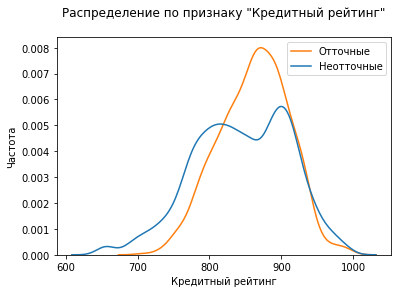

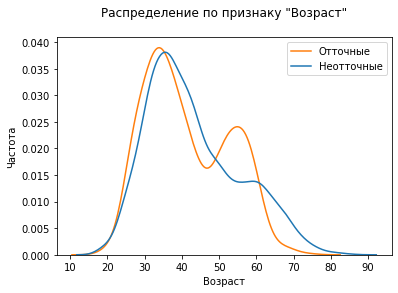

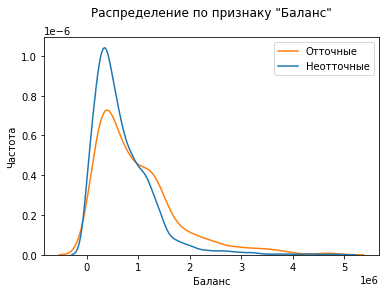

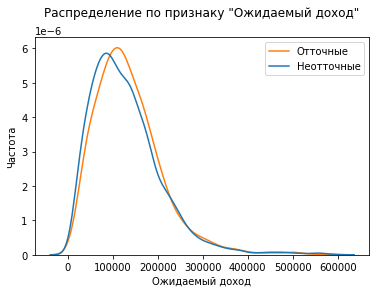

In [48]:
quantitative_feature_dict = {'score': 'Кредитный рейтинг',
                             'age': 'Возраст',
                             'balance': 'Баланс',
                             'est_salary': 'Ожидаемый доход'}
for feature in quantitative_feature_dict:
    sns.kdeplot(
        data=df,
        x=feature,
        hue='churn',
        common_norm=False
    )
    plt.title(f'Распределение по признаку "{quantitative_feature_dict[feature]}"\n')
    plt.legend(['Отточные', 'Неотточные'])
    plt.xlabel(quantitative_feature_dict[feature])
    plt.ylabel('Частота')
    plt.show()

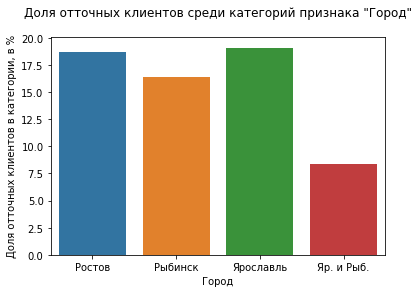

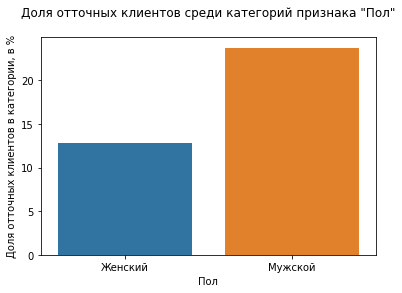

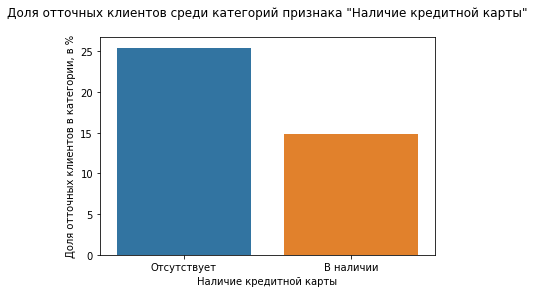

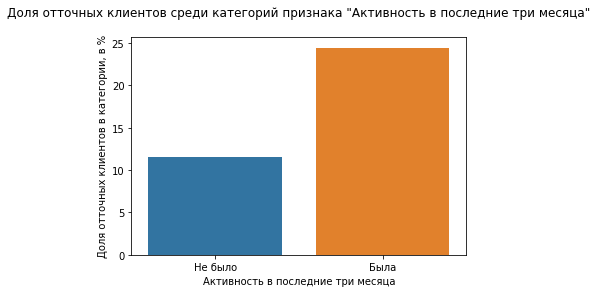

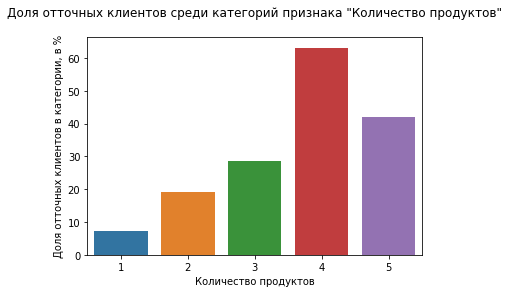

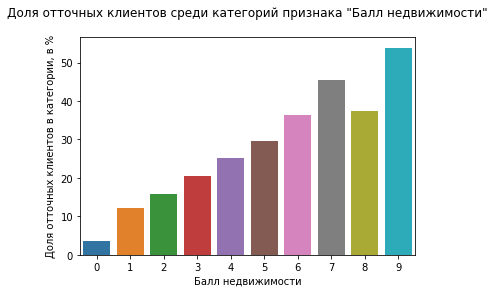

In [49]:
categorical_feature_dict = {'city': 'Город',
                            'gender': 'Пол',
                            'credit_card': 'Наличие кредитной карты',
                            'last_activity': 'Активность в последние три месяца',
                            'products': 'Количество продуктов',
                            'equity': 'Балл недвижимости'}

categorical_feature_dict_for_columns = {
    'city': ["Ростов", "Рыбинск", "Ярославль", "Яр. и Рыб."],
    'gender': ["Женский", "Мужской"],
    'credit_card': ["Отсутствует", "В наличии"],
    'last_activity': ["Не было", "Была"],
    'products': list(range(1, 6)),
    'equity': list(range(10))
}

for feature in categorical_feature_dict:
    data = df.query('churn==1').groupby([feature])[['user_id']].count() / \
        df.groupby([feature])[['user_id']].count() * 100
    sns.barplot(
        data=data,
        x=categorical_feature_dict_for_columns[feature],
        y='user_id'
    )
    plt.title(f'Доля отточных клиентов среди категорий признака "{categorical_feature_dict[feature]}"\n')
    plt.xlabel(categorical_feature_dict[feature])
    plt.ylabel('Доля отточных клиентов в категории, в %')
    plt.show()

**Проанализировав графики, можно сделать следующие выводы о характерных чертах отточных клиентов:**
* Возраст от 23 до 31 года, а также от 49 до 60.
* Баланс на счетах - свыше миллиона у.е.
* Предполагаемый доход клиентов - выше 100 тысяч у.е.
* Город не оказывает влияния на отточность.
* Пол - чаще мужской.
* Нет кредитной карты.
* Есть активность за последние 3 месяца.
* Чем больше продуктов, тем выше вероятность, что клиент будет отточным: 4 и 5 продуктов - сверх высокая отточность (около половины с таким количеством продуктов - отточные), 2 и3 продукта - средняя отточность (20-30% клиентов в категории).
* Чем выше балл недвижимости, тем выше вероятность оттока: начиная от 3 баллов отточность составляет 20%, для 5 баллов - 30%, для 7 и 9 - около 50%.

### Корреляционный анализ признаков

Построим и изучим тепловую карту, отобразив на ней коэффициенты корреляции Пирсона особо интересующих признаков:

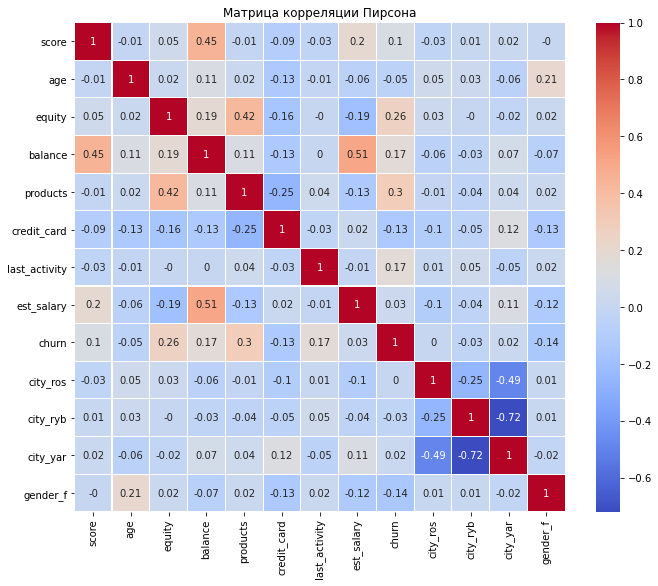

In [50]:
matrix = df.drop(columns=['user_id', 'gender_m']).corr().apply(lambda x: round(x, 2))

plt.figure(figsize=(11, 9))
sns.heatmap(matrix,
            annot=True,
            linewidth=0.1,
            cmap="coolwarm",
)
plt.title('Матрица корреляции Пирсона')
plt.show()

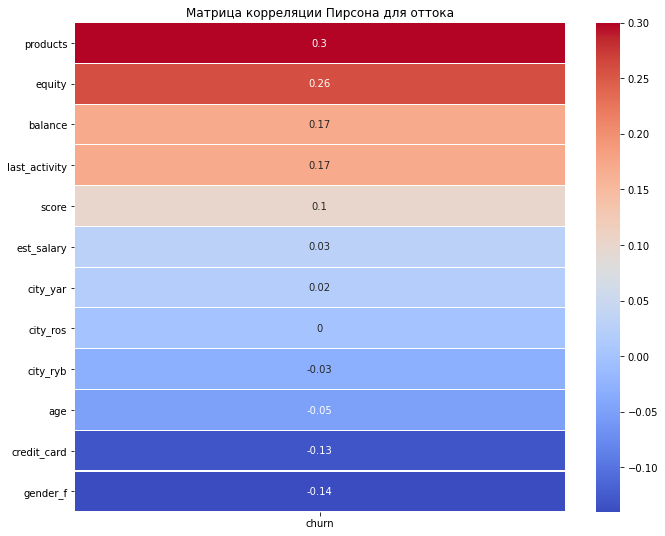

In [51]:
matrix = df.drop(columns=['user_id',
                          'gender_m']).corr().apply(lambda x: round(x, 2))[['churn']].sort_values(
                                                                                    by='churn', ascending=False).iloc[1:, :]

plt.figure(figsize=(11, 9))
sns.heatmap(matrix,
            annot=True,
            linewidth=0.1,
            cmap="coolwarm",
)
plt.title('Матрица корреляции Пирсона для оттока')
plt.show()

Заметим следующие особенности:
* Есть слабая корреляция оттока с количеством продуктов, баллами недвижимости, балансом и активностью клиента за последние 3 месяца.
* Заметна средняя корреляция баланса с кредитным рейтингом и предполагаемыми доходами клиента, а также слабая корреляция с баллом недвижимости и оттоком.
* Заметна средняя корреляция между количеством продуктов и баллом недвижимости, а также слабая корреляция с оттоком.

Теперь найдем значения корреляций с применением матрицы корреляций из библиотеки `phik`, что позволит найти нелинейные зависимости. В качестве значений аргумента `interval_cols` укажем непрерывные признаки: кредитный рейтинг, баланс и ожидаемый доход клиента. Результат также отобразим на тепловой карте.

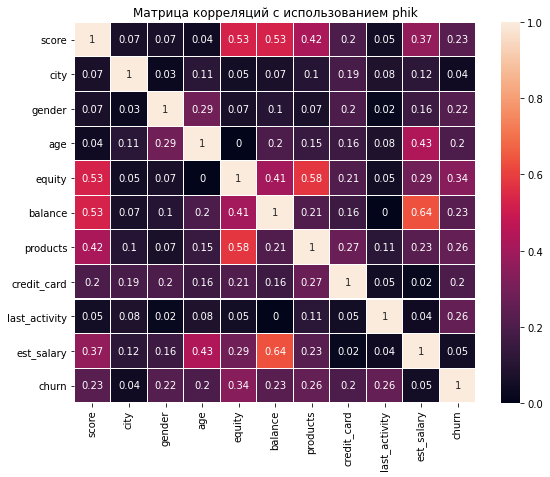

In [52]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.drop(columns=['user_id',
                 'gender_m',
                 'gender_f',
                 'city_ryb',
                 'city_ros',
                 'city_yar']
                    ).phik_matrix(interval_cols=['score',
                                                 'balance',
                                                 'est_salary']
                                 ).apply(lambda x: round(x, 2)),
            annot=True,
            linewidth=0.1,
)
plt.title('Матрица корреляций с использованием phik')
plt.show()

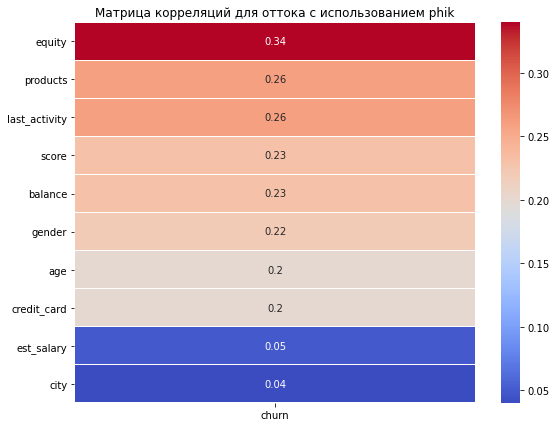

In [53]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.drop(columns=['user_id',
                 'gender_m',
                 'gender_f',
                 'city_ryb',
                 'city_ros',
                 'city_yar']
                    ).phik_matrix(interval_cols=['score',
                                                 'balance',
                                                 'est_salary']
                                 ).apply(lambda x: round(x, 2))[['churn']].sort_values(
                                                                                    by='churn', ascending=False
                                                                                    ).iloc[1:, :],
            annot=True,
            linewidth=0.1,
            cmap="coolwarm"
)
plt.title('Матрица корреляций для оттока с использованием phik')
plt.show()

В дополнение к ранее выявленным зависимостям можно добавить следующие:
* Кредитный рейтинг имеет средний уровень корреляции не только с балансом, но и с баллом недвижимости, что звучит логично: чаще всего жилье берут в ипотеку, а закрытая ипотека явно должна положительно сказываться на кредитном балле. Также стала заметная слабая корреляция с количеством продуктов и отточностью.
* Обнаружена средняя корреляция между возрастом с количеством продуктов и ожидаемыми доходами клиента.
* Обнаружена средняя корреляция между баллом недвижимости и балансом.
* Корреляция между количеством продуктов и отточностью усилилась.

Резюмируя, можно выделить следующие основные признаки, влияющие на отток:
* Наибольшая корреляция обнаружена с количеством продуктов и баллом недвижимости;
* Найдена слабая зависимость от активности за последние 3 месяца, балансом и кредитным рейтингом, а также с полом - как ранее было выяснено, мужчины чаще изъявляют желание прекратить взаимодействие с банком.

**Подведем итоги исследовательского анализа данных:**
1. Построены портреты типичных клиентов в разрезе отточности. Выявлено, что, в среднем, отточные клиенты - мужчины около 40 лет, с балансом на счетах около 800 тысяч у.е. и более дорогой недвижимостью во владении, активно пользующиеся различными продуктами банка, с кредитным рейтингом чуть выше, чем у всех клиентов. В свою очередь, портрет типичного удовлетворенного клиента выглядит так: женщина 43 лет из Ярославля с доходами около 115000 у.е., балансом на счетах - чуть выше полумиллиона, пользующаяся кредитной и дебетовой картой, имеющая во владении объект недвижимости.


2. Выявлены следующие факторы повышенного оттока:
    * Возраст от 23 до 31 года, а также от 49 до 60 лет.
    * Баланс на счетах - свыше миллиона у.е.
    * Предполагаемый доход - выше 100 тысяч у.е.
    * Пол - мужской.
    * Нет кредитной карты.
    * Есть активность за последние 3 месяца.
    * Количество продуктов более 2.
    * Высокий балл недвижимости.
  
  
3. Кроме того, обнаружена средняя корреляция:
    * между кредитным рейтингом, балансом и баллом недвижимости;
    * между возрастом с количеством продуктов и оценочным уровнем дохода клиента.

## Выдвижение и проверка статистических гипотез

### Гипотеза № 1. Доходы отточных клиентов выше, чем доходы неотточных.

Формализуем выдвинутую гипотезу. На основании ранее обнаруженных закономерностей и средних значений предполагается, что доходы отточных клиентов выше, чем у неотточных. Выдвинем нулевую гипотезу: "*Доходы отточных и неотточных клиентов равны*"; тогда альтернативная гипотеза звучит так: "*Доходы отточных клиентов выше, чем неотточных*". Статистикой в данном случае считаем выборочное среднее ожидаемых доходов клиентов `est_salary`. Рассчитаем стандартное отклонение и среднее доходов для обоих групп клиентов:

In [54]:
print('Стандартное отклонение доходов отточных клиентов:',
      df.query('churn == 1')['est_salary'].std())
print('Среднее значение доходов отточных клиентов:',
      df.query('churn == 1')['est_salary'].mean())
print()
print('Стандартное отклонение доходов НЕотточных клиентов:',
      df.query('churn == 0')['est_salary'].std())
print('Среднее значение доходов НЕотточных клиентов:',
      df.query('churn == 0')['est_salary'].mean())

Стандартное отклонение доходов отточных клиентов: 75255.33729167226
Среднее значение доходов отточных клиентов: 135094.49452193474

Стандартное отклонение доходов НЕотточных клиентов: 79142.05005942007
Среднее значение доходов НЕотточных клиентов: 128996.24033224263


Стандартные отклонения в выборках сопоставимы. Тем не менее, как было ранее выявлено, в данных есть выбросы, которые не были удалены, т.к. являются ценными для корректности исследования, что может негативно сказаться на результатах t-теста. С другой стороны, нельзя сказать, что их количество слишком велико; кроме того, из ранее построенных графиков распределения доходов `est_salary` видно, что значения распределены нормально и их досточно много, что удовлетворяет требованиям к применению t-критерия Стьюдента.

Ввиду сложившейся неопределенности, для проверки гипотезы применим как t-тест, так и u-критерий Манна Уитни. Так как количество имеющихся значений достаточно велико и составляет почти 10 тысяч, установим уровень статистической значимости равным 0,5%. Поскольку отточные и неотточные клиенты не зависят друг от друга, применяя t-тест будем использовать двухвыборочный тест для независимых выборок.

In [55]:
est_salary_churn_clients = list(df.query('churn == 1')['est_salary'])
est_salary_non_churn_clients = list(df.query('churn == 0')['est_salary'])

alpha = 0.005

t_test_results = st.ttest_ind(
    est_salary_churn_clients,
    est_salary_non_churn_clients,
    alternative='greater'
)

print('p-value по результатам t-теста:', t_test_results.pvalue)

if t_test_results.pvalue < alpha:
    print('По результатам t-теста отвергаем нулевую гипотезу')
else:
    print('По результатам t-теста не получилось отвергнуть нулевую гипотезу')
    
u_test_results = st.mannwhitneyu(est_salary_churn_clients,
                                 est_salary_non_churn_clients,
                                 alternative='greater')

print('\np-value по результатам u-теста:', u_test_results.pvalue)

if u_test_results.pvalue < alpha:
    print('По результатам u-теста отвергаем нулевую гипотезу')
else:
    print('По результатам u-теста не получилось отвергнуть нулевую гипотезу')

p-value по результатам t-теста: 0.001526273910784548
По результатам t-теста отвергаем нулевую гипотезу

p-value по результатам u-теста: 9.019256081130467e-06
По результатам u-теста отвергаем нулевую гипотезу


**Оба теста выдали довольно низкое значение p-value, что позволяет отвергнуть нулевую гипотезу и сделать статистически достоверный вывод о том, что доходы отточных клиентов превышают доходы неотточных.**

### Гипотеза № 2. Отточность клиентов зависит от количества используемых ими продуктов.

Проверим распределение данных на нормальность в разрезе отточности с помощью графиков распределения и QQ-графика:

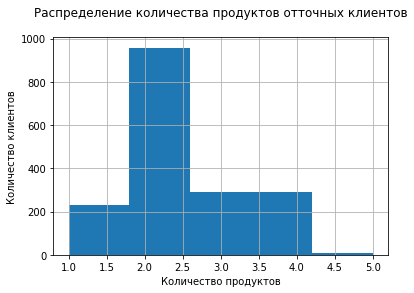

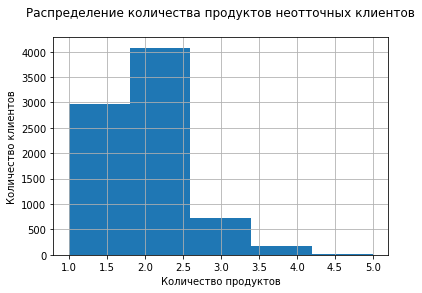

In [56]:
df.query('churn==1')['products'].hist(bins=5)
plt.title('Распределение количества продуктов отточных клиентов\n')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.show()
df.query('churn==0')['products'].hist(bins=5)
plt.title('Распределение количества продуктов неотточных клиентов\n')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.show()

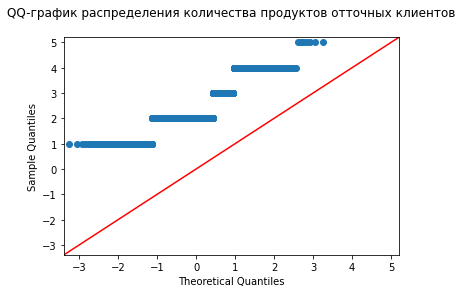

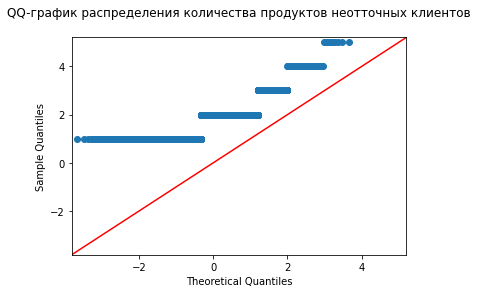

In [57]:
sm.qqplot(df.query('churn==1')['products'], line='45')
plt.title('QQ-график распределения количества продуктов отточных клиентов\n')
plt.show()
sm.qqplot(df.query('churn==0')['products'], line='45')
plt.title('QQ-график распределения количества продуктов неотточных клиентов\n')
plt.show()

Значения нельзя назвать нормально распределенными: значит, применение t-теста в данном случае недопустимо.

С учетом того, что:

- количество продуктов - целочисленная величина, измеримая в порядковой шкале;
- общее количество значений в обоих группах отточности достаточно велико;
- группы отточных и неотточных пользователей независимы,

**применим критерий независимости хи-квадрат Пирсона.**

Нулевая гипотеза - отточность клиентов не зависит от количества используемых ими продуктов. Альтернативная гипотеза - зависимость между отточностью и количество продуктов имеется. Уровень стат. значимости укажем в размере 0,1%. Построим таблицу сопряженности описанных признаков и воспользуемся хи-квадрат тестом на независимость.

In [58]:
# готовим таблицу сопряженности products и churn
df_grouped_by_products = df.groupby(['churn', 'products']).agg({'user_id': 'count'})['user_id']
df_grouped_by_products_non_churn = df_grouped_by_products[:5]
df_grouped_by_products_churn = df_grouped_by_products[5:]

contingency_table_products_and_churn = [list(df_grouped_by_products_non_churn)] + [list(df_grouped_by_products_churn)]

# применяем хи-квадрат тест независимости, выбрав уровень стат. значимости в размере 0.1%
alpha = 0.001

chi2_contingency_results = st.chi2_contingency(contingency_table_products_and_churn)

print('p-value по результатам хи-квадрат теста незавимости:', chi2_contingency_results[1])

if chi2_contingency_results[1] < alpha:
    print('По результатам хи-квадрат теста незавимости отвергаем нулевую гипотезу')
else:
    print('По результатам хи-квадрат теста незавимости не получилось отвергнуть нулевую гипотезу')

p-value по результатам хи-квадрат теста незавимости: 2.2127532466617343e-207
По результатам хи-квадрат теста незавимости отвергаем нулевую гипотезу


p-value получилось экстремально низким. **Значит, нулевую гипотезу отвергаем и считаем, что количество продуктов, используемых клиентами, влияет на фактор оттока.**

### Гипотеза № 3. Отточность клиентов зависит от количества баллов недвижимости.

Заметим, что баллы недвижимости характеризуются теми же свойствами, что и количество продуктов, в связи с чем для проверки статистической гипотезы можно также применить критерий хи-квадрат Пирсона. Нулевая гипотеза: отточность клиентов не зависит от балла недвижимости. Альтернативная гипотеза - зависимость между отточностью и баллом недвижимости имеется. Уровень стат. значимости также укажем в размере 0,1%.

In [59]:
# готовим таблицу сопряженности equity и churn
df_grouped_by_equity = df.groupby(['churn', 'equity']).agg({'user_id': 'count'})['user_id']
df_grouped_by_equity_non_churn = df_grouped_by_equity[:10]
df_grouped_by_equity_churn = df_grouped_by_equity[10:]

contingency_table_equity_and_churn = [list(df_grouped_by_equity_non_churn)] + [list(df_grouped_by_equity_churn)]

# применяем хи-квадрат тест независимости, выбрав уровень стат. значимости в размере 0.1%
alpha = 0.001

chi2_contingency_results = st.chi2_contingency(contingency_table_equity_and_churn)

print('p-value по результатам хи-квадрат теста незавимости:', chi2_contingency_results[1])

if chi2_contingency_results[1] < alpha:
    print('По результатам хи-квадрат теста незавимости отвергаем нулевую гипотезу')
else:
    print('По результатам хи-квадрат теста незавимости не получилось отвергнуть нулевую гипотезу')

p-value по результатам хи-квадрат теста незавимости: 1.7531680389501406e-142
По результатам хи-квадрат теста незавимости отвергаем нулевую гипотезу


p-value крайне мало. **Значит, принимаем, что балл недвижимости влияет на фактор оттока.**

**Подведем итоги проверки статистических гипотез:**
1. Доходы отточных клиентов превышают доходы неотточных.
2. Количество продуктов, используемых клиентами, влияет на фактор оттока.
3. Балл недвижимости клиента также влияет на фактор оттока.

## Сегментация клиентов

В рамках сегментации клиентов будем считать, что сегмент выделен эффективно при условиях:
* размер сегмента составляет от 250 до 2000 человек;
* сегмент сформирован на основании 2-4 признаков;
* уровень оттока в сегменте составляет не менее 36%.

Для автоматизации процесса создадим функцию, принимающую на вход признаки, наиболее сильно влияющие на отточность (на основании ранее полученных выводов) и формирующую на их основе сегменты клиентов. В результате функция возвращает все комбинации признаков в порядке убывания процента отточных клиентов, при этом сегменты должны удовлетворять приведенным выше правилам.

In [60]:
def find_best_segmentation(df, features_dict):
    """
    Функция принимает на вход датафрейм и словарь в формате название признака: значение признака.
    При передаче словаря должны использоваться только количественные признаки,
    при этом функция будет искать такие строки датафрейма, которые будут строго выше указанных значений признаков.
    """
    
    # создаем датафрейм, в который будем добавлять все удовлетворяющие наборы признаков
    good_data = pd.DataFrame({'features': [], 'segment_size': [], 'churn_rate': []})
    
    # перебираем всевозможные комбинации признаков, при этом берем от 2 до 4 признаков
    for combo_amount in range(2, 5):
        for features_combo in combinations(features_dict, combo_amount):
            # создаем новый временный датафрейм, который далее будет отфильтрован по указанным признакам
            data = df.copy()
            for feature in features_combo:
                data = data[data[feature] > features_dict.get(feature)]
            # если датафрейм удовлетворяет условиям, то добавляем основные значения в good_data
            if len(data) < 2000 and len(data) > 300 and (len(data.query('churn==1')) / len(data)) > 0.36:
                good_data.loc[len(good_data.index)] = np.array([', '.join(features_combo),
                                                       len(data),
                                                       (round(len(data.query('churn==1')) / len(data) * 100, 1))], dtype=object)
    
    # сортируем датафрейм с итоговыми значениями по убыванию доли отточных клиентов
    good_data = good_data.sort_values(by='churn_rate', ascending=False).reset_index()
    del good_data['index']
    return good_data

В качестве значений признаков, на основании которых можно эффективно сегментировать клиентов, выберем следующие:
* ожидаемый доход клиента `est_salary` более 110 тыс. у.е.;
* количество баллов недвижимости `equity` больше трёх;
* количество продуктов `products` больше двух;
* баланс - от 1 миллиона у.е.;
* возраст - от 30 лет;
* наличие кредитной карты;
* пол - мужской;
* кредитный рейтинг - выше 800;
* есть активность за последние 3 месяца.

In [61]:
segments = find_best_segmentation(df,{'est_salary': 110_000,
                            'equity': 3,
                            'products': 2,
                            'balance': 1_000_000,
                            'age': 30,
                            'credit_card': 0,
                            'gender_m': 0,
                            'score': 850,
                            'last_activity': 0
})

# укажем долю отточных клиентов в сегменте от всех отточных клиентов
segments['churn_rate_total'] = round(segments['segment_size'] * segments['churn_rate'] / len(df.query('churn==1')), 1)

In [62]:
segments.head(15)

,features,segment_size,churn_rate,churn_rate_total
0,"equity, gender_m, score, last_activity",528.0,68.8,20.4
1,"est_salary, equity, score, last_activity",643.0,67.8,24.5
2,"est_salary, equity, products, score",320.0,66.9,12.0
3,"equity, balance, score, last_activity",494.0,66.0,18.3
4,"products, balance, score",378.0,65.6,13.9
5,"products, balance, age, score",357.0,64.7,13.0
6,"products, balance, last_activity",301.0,64.5,10.9
7,"products, gender_m, score",357.0,64.4,12.9
8,"equity, balance, gender_m, last_activity",358.0,64.2,12.9
9,"est_salary, products, credit_card",332.0,63.9,11.9


In [63]:
segments.sort_values(by='churn_rate_total', ascending=False).head(15)

,features,segment_size,churn_rate,churn_rate_total
99,"equity, gender_m",1963.0,37.7,41.6
103,"equity, age, last_activity",1759.0,37.3,36.9
27,"equity, score, last_activity",1105.0,57.0,35.4
104,"equity, age, gender_m",1633.0,37.0,34.0
76,"est_salary, equity, score",1278.0,44.8,32.2
88,"equity, balance",1332.0,39.9,29.9
63,"equity, gender_m, score",1090.0,48.5,29.7
92,"products, age",1305.0,39.3,28.8
58,"est_salary, equity, last_activity",1024.0,49.8,28.7
80,"est_salary, equity, age, score",1160.0,43.4,28.3


Выделим наилучшие из обнаруженных сегментов, при этом выбирая такие, группировка которых может быть обоснована. Также учитываем, что сегменты на данном этапе могут иметь пересечения друг с другом.
1. Клиенты с баллом недвижимости и кредитными рейтингом выше среднего, с доходами свыше 110 тыс. у.е. и проявлявшие активность за последние 3 месяца: **643 клиента, отточность внутри сегмента: 67,8%, доля от всех отточных клиентов: 24,5%**. Данный сегмент является наиболее приоритетным: почти четверть от всех отточных клиентов попадает в данную категорию, при этом отточность внутри сегмента - одна из наибольших. Данный сегмент можно описать так: клиенты с уровнем доходов выше среднего, владеющие недвижимостью и с хорошим кредитным рейтингом, которые проявляли активность в последнее время и остались чем-то не удовлетворены. Сочетание высокого кредитного рейтинга и высокого балла недвижимости говорит о том, что клиент, скорее всего, либо уже успешно выплатил ипотеку, либо ещё выплачивает её, но является добросовестным клиентом - данный факт также повышает важность удержания именно этого сегмента.


2. В случае, если у банка появится возможность обработать больше отточных клиентов, следует рассмотреть более объемный сегмент, схожий с предыдущим: в сегмент также попали клиенты с  баллом недвижимости и кредитными рейтингом выше среднего и проявлявшие активность за последние 3 месяца (не учитывает ограничение по доходам): **1105 клиентов, отточность внутри сегмента: 57%, доля от всех отточных клиентов: 35,4%**.

Попробуем убрать признаки `est_salary`, `score` и `last_activity`, ослабим требования к балансу и количеству продуктов, а также усилим требования к возрасту: рассмотрим клиентов в возрасте от 51 до 60 лет (не включительно), чтобы определить возможные закономерности среди других признаков:

In [64]:
segments = find_best_segmentation(df.query('age < 60'),
                                  {'products': 2,
                                   'balance': 850_000,
                                   'age': 51,
                                   'credit_card': 0,
                                   'gender_m': 0,
                                   'equity': 3
})

segments['churn_rate_total'] = round(segments['segment_size'] * segments['churn_rate'] / len(df.query('churn==1')), 1)
segments.head(15)

,features,segment_size,churn_rate,churn_rate_total
0,"products, balance, gender_m",308.0,65.9,11.4
1,"products, balance, equity",402.0,62.7,14.2
2,"products, balance",544.0,60.3,18.4
3,"products, credit_card, equity",393.0,54.7,12.1
4,"products, gender_m, equity",474.0,54.0,14.4
5,"products, credit_card, gender_m",397.0,53.9,12.0
6,"products, credit_card",618.0,51.1,17.8
7,"products, gender_m",690.0,50.4,19.6
8,"balance, gender_m, equity",789.0,49.6,22.0
9,"products, equity",807.0,47.8,21.7


Также рассмотрим срез клиентов в возрасте от 25 до 35 лет (не включая пределы):

In [65]:
segments = find_best_segmentation(df.query('age < 35'),
                                  {
                                    'products': 2,
                                    'balance': 850_000,
                                    'age': 25,
                                    'credit_card': 0,
                                    'gender_m': 0,
                                    'equity': 3
})

segments['churn_rate_total'] = round(segments['segment_size'] * segments['churn_rate'] / len(df.query('churn==1')), 1)
segments.head(15)

,features,segment_size,churn_rate,churn_rate_total
0,"balance, equity",303.0,54.1,9.2
1,"products, age",350.0,45.7,9.0
2,"age, gender_m, equity",576.0,42.4,13.7
3,"gender_m, equity",655.0,41.4,15.3
4,"balance, age, gender_m",369.0,36.9,7.7
5,"balance, gender_m",391.0,36.6,8.0


Продолжим предыдущий список сегментов с учетом новых данных:

3. Клиенты до 60 лет, пользующиеся кредиткой и использующие 3 и более продуктов банка: **618 клиентов, отточность внутри сегмента: 51,1%, доля всех отточных клиентов: 17,8%.** Можно сделать вывод о том, что это активные клиенты, пользующиеся кредиткой и другими продуктами банка, которые недовольны одним из продуктов. Возможно, эти клиенты давно с банком (т.к. имеют несколько продуктов в банке), но их перестали устраивать условия банка в отношении кредитных карт.

4. Клиенты до 60 лет, имеющие 3 и более продукта в банке, а баланс на счетах - свыше 850 тысяч у.е.: **544 клиента, отточность внутри сегмента: 60,3%, доля всех отточных клиентов: 18,4%**. Скорее всего, данный сегмент будет иметь много пересечений с сегментом, выделенном в пункте 3, однако, тем не менее, данныю группу также стоит выделить ввиду высокой отточности внутри сегмента. Поскольку у данных клиентов много средств на счетах, а также много продуктов банка, можно предположить, что основа этих продуктов - вклады и накопительные счета. Клиенты, вероятно, остались недовольны процентными ставками в банке и решили уйти к конкуренту. С учетом того, что эти клиенты обладают большими денежными средствами, они имеют дополнительную ценность для банка.

5. Клиенты-мужчины в возрасте от 25 до 35 лет с высоким баллом недвижимости (более трех): **576 клиентов, отточность внутри сегмента: 42,4%, доля всех отточных клиентов: 13,7%**. Это ценные клиенты для банка, платежеспособность которых со временем будет, скорее всего, только расти.

Теперь строго отделим сегменты друг от друга, чтобы избежать эффекта пересечения множеств, и найдем суммарную долю отточных клиентов с учетом выделенных сегментов:

In [66]:
# создаем функцию, которая выводит размеры сегментов и их отточность на основании заданных правил фильтрации
def calc_segment_size_and_churn_rate(df, rules_list):
    result = pd.DataFrame({'rules_list': [], 'segment_size': [], 'churn_rate': []})
    for rule in rules_list:
        segment = df.query(rule)
        result = result.append({'rules_list': rule,
                       'segment_size': len(segment),
                       'churn_rate': round(len(segment.query('churn==1')) / len(segment) * 100, 1)}, ignore_index=True)
    return result 

# убираем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

rules_list = ['equity > 3 and score > 850 and last_activity == 1',
              'equity > 3 and score > 850 and last_activity == 1 and est_salary > 110_000',
             'credit_card == 1 and products > 2 and age < 60',
             'products > 2 and balance > 850_000 and age < 60',
             'age > 25 and age < 35 and gender_m == 1 and equity > 3']

# выводим информацию по сегментам
df_segments_info = calc_segment_size_and_churn_rate(df, rules_list)
df_segments_info.columns = ['Правила сегментации', 'Размер сегмента', 'Уровень оттока, в %']
display(df_segments_info)

# выводим общую информацию об отточости
df_segments = df.query('(equity > 3 and score > 850 and last_activity == 1) or \
                       (equity > 3 and score > 850 and last_activity == 1 and est_salary > 110_000) or \
                        (credit_card == 1 and products > 2 and age < 60) or \
                        (products > 2 and balance > 850_000 and age < 60) or \
                        (age > 25 and age < 35 and gender_m == 1 and equity > 3)')

print('\nДоля отточных клиентов, суммарно покрытых выбранными сегментами: ',
      round(len(df_segments.query('churn == 1')) / len(df.query('churn == 1')) * 100, 1), '%', sep='')
print('Общая доля отточных клиентов среди всех клиентов в рамках выбранных сегментов: ',
      round(len(df_segments.query('churn == 1')) / len(df_segments) * 100, 1), '%', sep='')

,Правила сегментации,Размер сегмента,"Уровень оттока, в %"
0,equity > 3 and score > 850 and last_activity == 1,1105.0,57.0
1,equity > 3 and score > 850 and last_activity == 1 and est_salary > 110_000,643.0,67.8
2,credit_card == 1 and products > 2 and age < 60,618.0,51.1
3,products > 2 and balance > 850_000 and age < 60,544.0,60.3
4,age > 25 and age < 35 and gender_m == 1 and equity > 3,576.0,42.4



Доля отточных клиентов, суммарно покрытых выбранными сегментами: 56.1%
Общая доля отточных клиентов среди всех клиентов в рамках выбранных сегментов: 47.4%


Подготовим таблицу, указав номера сегментов:

In [67]:
df_segments_info['Правила сегментации'] = list(map(lambda x: f'Сегмент №{x}', range(1, 6)))
df_segments_info = df_segments_info.rename(columns={'Правила сегментации': "Номер сегмента"})
df_segments_info

,Номер сегмента,Размер сегмента,"Уровень оттока, в %"
0,Сегмент №1,1105.0,57.0
1,Сегмент №2,643.0,67.8
2,Сегмент №3,618.0,51.1
3,Сегмент №4,544.0,60.3
4,Сегмент №5,576.0,42.4


Суммарно сегментами покрыто 56,1% от всех отточных клиентов. При этом сегменты выделены достаточно эффективно: общая доля отточных клиентов внутри суммы всех сегментов составляет 47,4%, что является достаточным уровнем отточности: почти каждый второй клиент из выделенных сегментов заявляет об уходе.

**Резюмируя этап сегментации клиентов, выделим ключевые результаты:**
1. Проведено сегментирование на 5 групп клиентов, позволившее покрыть 56,1% всех отточных клиентов. Сегментирование достаточно эффективно, т.к. общая доля отточных клиентов внутри суммы выделенных сегментов составила 47,4%.
2. Выделены следующие сегменты, отсортированные по приоритету их обработки работниками банка (приоритет учитывает долю отточных клиентов в сегменте и относительную ценность клиентов для бизнеса):
    * Клиенты с баллом недвижимости выше 3 баллов, кредитными рейтингом выше 850 баллов, доходами свыше 110 тыс. у.е. и проявлявшие активность за последние 3 месяца.
    * Клиенты до 60 лет, имеющие 3 и более продуктов в банке, а баланс на счетах - свыше 850 тысяч у.е.
    * Клиенты до 60 лет, также имеющие 3 и более продуктов в банке, но пользующиеся кредитной картой.
    * Клиенты-мужчины в возрасте от 25 до 35 лет, с баллом недвижимости выше 3.
    * Оставшиеся клиенты с характеристиками из первого сегмента данного списка, но без ограничений по доходам.

## Общие выводы и рекомендации

Подводя итоги, по результатам проведенного исследования:

1. Было проведено изучение и предобработка исходных данных о клиентах банка: обработаны пропуски, дубликаты и аномалии, а также проведена замена типов данных.


2. Построены портреты типичных клиентов в разрезе отточности.
    * Портрет отточного клиента: мужчина около 40 лет, с балансом на счетах около 800 тысяч у.е. и более дорогой недвижимостью во владении, активно пользующийся различными продуктами банка, с кредитным рейтингом чуть выше, чем у всех клиентов. 
    * Портрет типичного удовлетворенного клиента: женщина 43 лет из Ярославля с доходами около 115000 у.е., балансом на счетах - чуть выше полумиллиона, пользующаяся кредитной и дебетовой картой, имеющая во владении объект недвижимости.


3. Выявлены  факторы повышенного оттока:
    - Возраст от 23 до 31 года, а также от 49 до 60 лет.
    - Баланс на счетах - свыше миллиона у.е.
    - Предполагаемый доход - выше 100 тысяч у.е.
    - Пол - мужской.
    - Нет кредитной карты.
    - Есть активность за последние 3 месяца.
    - Количество продуктов более 2.
    - Высокий балл недвижимости.


4. Проведена проверка трех статистических гипотез со следующими результатами:
    * Доходы отточных клиентов превышают доходы неотточных.
    * Количество продуктов, используемых клиентами, влияет на фактор оттока.
    * Балл недвижимости клиента также влияет на фактор оттока.
    
    
5. Проведено сегментирование на 5 групп клиентов, позволившее покрыть 56,1% всех отточных клиентов. Сегментирование достаточно эффективно, т.к. общая доля отточных клиентов внутри суммы выделенных сегментов составила 47,4%. Выделены следующие сегменты, отсортированные по приоритету их обработки работниками банка (приоритет учитывает долю отточных клиентов в сегменте и относительную ценность клиентов для бизнеса):
    * Клиенты с баллом недвижимости выше 3 баллов, кредитными рейтингом выше 850 баллов, доходами свыше 110 тыс. у.е. и проявлявшие активность за последние 3 месяца.
    * Клиенты до 60 лет, имеющие 3 и более продуктов в банке, а баланс на счетах - свыше 850 тысяч у.е.
    * Клиенты до 60 лет, также имеющие 3 и более продуктов в банке, но пользующиеся кредитной картой.
    * Клиенты-мужчины в возрасте от 25 до 35 лет, с баллом недвижимости выше 3.
    * Оставшиеся клиенты с характеристиками из первого сегмента данного списка, но без ограничений по доходам.    

**По итогам проделанной работы, менеджеру отдела маркетинга можно предложить следующие рекомендации по снижению отточности клиентов:**

1. Следует проанализировать последние обновления условий по дебетовым и кредитным картам, в том числе комиссий за переводы и прочие операции: что-то смутило финансово обеспеченных клиентов, в результате чего около 2/3 тех из них, кто пользовался банком за последние 3 месяца, попали в отток. Если такие действия действительно имели место быть, то чтобы остановить отток, следует пересмотреть политику банка в данных вопросах.

2. Возможно, клиенты выплачивают ипотеку по довольно высоким процентам, а среди банков-конкурентов появилось намного более выгодное предложение, в результате чего клиент принимает решение о рефинансировании кредита в другом банке. Причиной этого могло, например, стать изменение ключевой ставки Центрального банка или ситуации на рынке недвижимости. Чтобы уменьшить отточность и увеличить лояльность клиентов с ипотекой, стоит самостоятельно предложить таким клиентам снизить ставку по кредиту, чтобы не допустить его уход к конкуренту.

3. Чтобы уменьшить отточность среди клиентов до 60 лет, имеющих больше 850 тыс. у.е. на счетах и более 3 продуктов, стоит предложить им более выгодные условия в сравнении с конкурентами: например, можно увеличить процентную ставку по вкладам свыше миллиона на несколько долей процентных пунктов (в зависимости от текущих значений и предложений конкурентов), чтобы добиться большей привлекательности таких продуктов для клиента.

4. Для уменьшения отточности среди клиентов до 60 лет с кредитками и использующими более 3 продуктов банка, можно увеличить кредитный лимит для клиентов без просрочек и с кредитным рейтингом выше среднего: это позволит увеличить лояльность данного сегмента клиентов и снизит шанс их оттока.

5. Для удержания клиентов-мужчин в возрасте от 25 до 35 лет с баллом недвижимости выше 3, можно провести опрос о функционале приложения банка: например, попросить оставить отзыв о том, какий функций не хватает этим клиентам, или что они находят не особо удобным. Данная обратная связь может оказаться очень ценной для банка и позволит удержать данный сегмент.